In [1]:
import numpy as np
import glob
import os

import matplotlib.pyplot as plt

from scripts_fermions.operators import Hamiltonian, Boost
import yastn
from yastn.tn import mps

In [2]:
g = 1
v, Q = 1, 1
N = 256
D = 128
a = 0.125
m = 0.5
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/state_t=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fns = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", "dt=0.0625", f"{N=}", f"{D=}", f"{a=:0.4f}", f"{m=:0.4f}"])]);

In [3]:
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fex = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
fex

['/home/marek/pdf/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/ex/state_D=128.npy']

In [4]:
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
fgs

['/home/marek/pdf/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/gs/state_D=128.npy']

In [5]:
def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items()) ][0]

In [6]:
d_ex = np.load(fn_mass(fex, m=m), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs, m=m), allow_pickle=True).item()
psi_ex = yastn.from_dict(d_ex['psi'])
psi_gs = yastn.from_dict(d_gs['psi'])

In [7]:
prob_t = {}
ts = np.linspace(0, 16, 17)
psi_t = {t: yastn.from_dict(np.load(fn_mass(fns, t=t), allow_pickle=True).item()['psi']) for t in ts}

In [8]:
prob_gs = {t: np.abs(mps.vdot(xx, psi_gs)) ** 2  for t, xx in psi_t.items()}
prob_ex = {t: np.abs(mps.vdot(xx, psi_ex)) ** 2  for t, xx in psi_t.items()}

In [9]:
ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')
K = Boost(N, m, g, a, ops)
H = Hamiltonian(N, m, g, t=0, a=a, v=1, Q=0, ops=ops)

psi = psi_ex.copy()

opts_svd={"D_total": 64}
chis = np.linspace(0, 1, 21)

opts_expmv = {'hermitian': True, 'tol': 1e-10}
evol = mps.tdvp_(psi, K, chis, method='12site', opts_svd=opts_svd, dt=0.05, yield_initial=True, precompute=False, subtract_E=True, opts_expmv=opts_expmv)

EE = []
EE2 = []

probs = {}

for info in evol:
    EE.append(mps.vdot(psi, H, psi))
    EE2.append(mps.vdot(psi, H @ H, psi))
    chi = info.tf
    probs[chi] = {t: np.abs(mps.vdot(xx, psi)) ** 2  for t, xx in psi_t.items()}
    print(f"{info.tf:0.2f}", EE[-1].real, EE2[-1].real - (EE[-1].real) ** 2)

0.00 -650.9475000080869 6.078043952584267e-07
0.05 -650.9454957135129 0.0003490668023005128
0.10 -650.9397744451187 0.00043885945342481136
0.15 -650.9303015518324 0.0005034524365328252
0.20 -650.9169936655716 0.0006423359736800194
0.25 -650.8997990190902 0.0008769539417698979
0.30 -650.8786945376316 0.0011772974394261837
0.35 -650.853654460807 0.0015118942828848958
0.40 -650.8246264491647 0.0018783273990266025
0.45 -650.7915323965534 0.0022992907324805856
0.50 -650.7542850624677 0.0027950756484642625
0.55 -650.7127996179189 0.003367697063367814
0.60 -650.6669896300881 0.004007353680208325
0.65 -650.6167559390898 0.004715370887424797
0.70 -650.5619835443708 0.005500863830093294
0.75 -650.5025457085908 0.006377574056386948
0.80 -650.4383091752186 0.00735472037922591
0.85 -650.369134420094 0.008436871459707618
0.90 -650.2948729166733 0.009630982181988657
0.95 -650.2153656584496 0.010947068280074745
1.00 -650.130443663694 0.01239644712768495


In [10]:
E_ex = mps.vdot(psi_ex, H, psi_ex).real
E_gs = mps.vdot(psi_gs, H, psi_gs).real

Text(0.5, 0, 'chi')

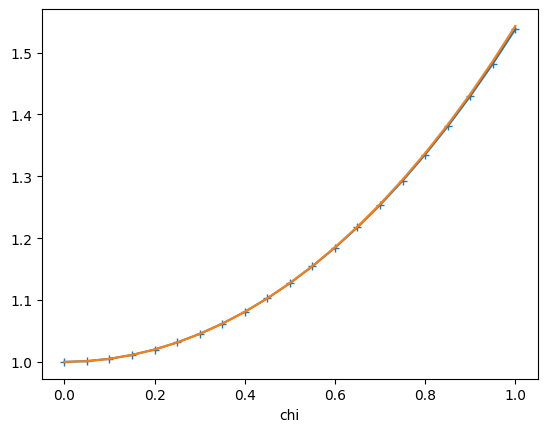

In [11]:
dE = np.array(EE).real - E_gs
plt.plot(chis, dE / dE[0], '-+')
plt.plot(chis, np.cosh(chis))
plt.xlabel("chi")


In [12]:
chis

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

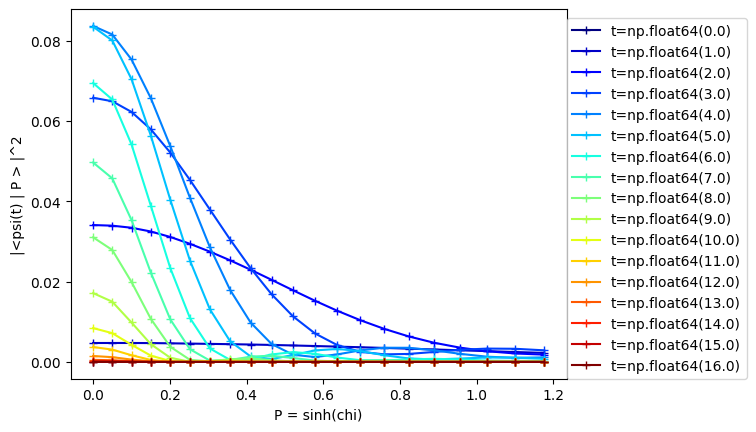

In [18]:
cm = plt.cm.jet
for t in ts:

    pr = [probs[chi][t] for chi in chis]
    P = np.sinh(chis)
    plt.plot(P, pr, '-+', label=f"{t=}", color = cm(t / ts[-1]))
plt.xlabel('P = sinh(chi)')
plt.ylabel("|<psi(t) | P > |^2")
plt.legend(loc=(1, 0))